In [20]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys
import seaborn as sns

(c) We now consider that this consumer has installed a battery, and analyze the impact
on its flexibility and profits.

iv. (1 point) Implement this optimization problem in a programming language of your
choice. Provide a well-documented working code.

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 192 columns and 432 nonzeros
Model fingerprint: 0xf982a31a
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 100 rows and 27 columns
Presolve time: 0.00s
Presolved: 93 rows, 165 columns, 304 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2060000e+31   6.855000e+31   2.206000e+01      0s
      62    2.7125594e+01   0.000000e+00   0.000000e+00      0s

Solved in 62 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.712559444e+01

Hourly schedule (hours 0..23):
 t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | p_ch | p_dis | SOC | impo

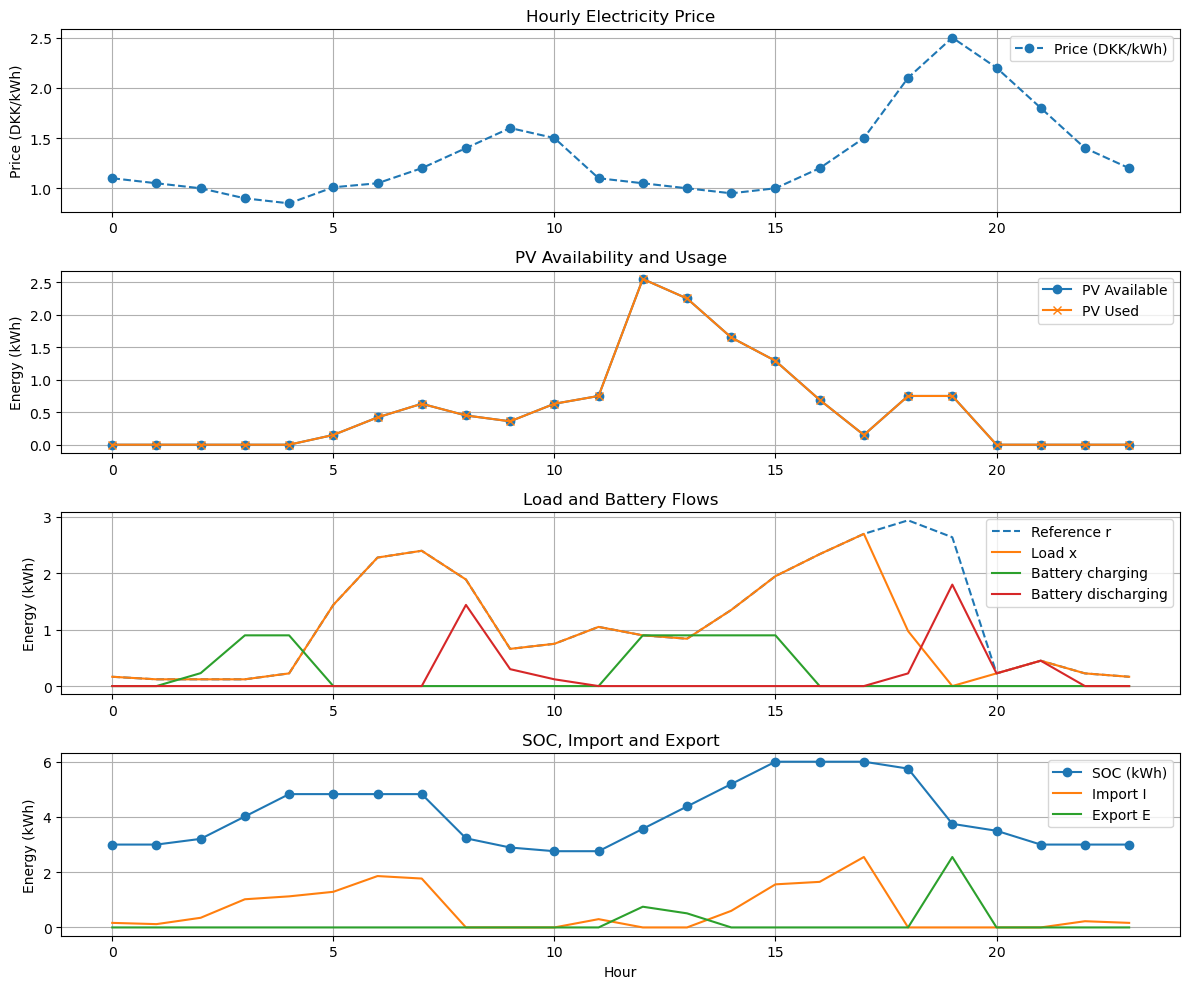

In [ ]:
# Utility to load JSON
def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None

# Paths
base_folder = Path("data/question_1c/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preferences.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption for this assignment
consumer = consumer_params[0]
bus = bus_params[0]

# Extract specs
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

storage_spec = appliance_params["storage"][0]
storage_id = storage_spec["storage_id"]
C = float(storage_spec["storage_capacity_kWh"])  # capacity (kWh)
max_charging_power_ratio = float(storage_spec["max_charging_power_ratio"])
max_discharging_power_ratio = float(storage_spec["max_discharging_power_ratio"])
eta_ch = float(storage_spec["charging_efficiency"])
eta_dis = float(storage_spec["discharging_efficiency"])

P_ch_max = max_charging_power_ratio * C  # kW (kWh per hour)
P_dis_max = max_discharging_power_ratio * C


storage_prefs = usage_pref[0].get("storage_preferences", [])

initial_soc_ratio = float(storage_prefs[0]["initial_soc_ratio"])
final_soc_ratio = float(storage_prefs[0]["final_soc_ratio"])

SOC0 = initial_soc_ratio * C
SOC_final_required = final_soc_ratio * C


prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit("Expected 24 hourly prices; got %d" % len(prices))

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")

pv_avail = [pv_max_kW * float(r) for r in der_profile]

# Usage preferences: reference hourly profile ratios
load_prefs = usage_pref[0].get("load_preferences", [])
if not load_prefs:
    raise SystemExit("No load_preferences found in usage_preference.json")
lp0 = load_prefs[0]
hourly_profile_ratio = lp0.get("hourly_profile_ratio", None)
if hourly_profile_ratio is None or len(hourly_profile_ratio) != 24:
    raise SystemExit("Expected a 24-entry hourly_profile_ratio for the load in usage_preference.json")

# Reference profile r_t = ratio * max_load (kWh per hour)
r = [float(ratio) * load_max_kWh for ratio in hourly_profile_ratio]

# Discomfort penalty gamma (DKK per kWh)
gamma = 2

T = list(range(24))

# Build model
m = gp.Model("consumer_flex_lp_with_battery_and_discomfort")
m.setParam('OutputFlag', 1)

# Variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")          # cap by PV availability constraints
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")
d = m.addVars(T, lb=0.0, name="d")         # absolute deviation variables

# Battery variables
p_ch = m.addVars(T, lb=0.0, ub=P_ch_max, name="p_ch")   # charging power (kW)
p_dis = m.addVars(T, lb=0.0, ub=P_dis_max, name="p_dis") # discharging power (kW)
SOC = m.addVars(T, lb=0.0, ub=C, name="SOC")            # SOC at end of each hour (kWh)

# PV availability constraints
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Energy balance (including battery)
# I - E + u + p_dis = x + p_ch
for t in T:
    m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")

# Load upper bound (already in var definition, but keep for clarity)
for t in T:
    m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

# Deviation linearization constraints: d_t >= x_t - r_t and d_t >= r_t - x_t
for t in T:
    m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
    m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")
    # d[t] >= 0 is enforced by variable lb

# Battery SoC dynamics
# SOC[0] = SOC0 + eta_ch * p_ch[0] - (1/eta_dis) * p_dis[0]
# SOC[t] = SOC[t-1] + eta_ch * p_ch[t] - (1/eta_dis) * p_dis[t] for t >= 1
m.addConstr(SOC[0] == SOC0 + eta_ch * p_ch[0] - (1.0/eta_dis) * p_dis[0], name="soc_0")
for t in T[1:]:
    m.addConstr(SOC[t] == SOC[t-1] + eta_ch * p_ch[t] - (1.0/eta_dis) * p_dis[t], name=f"soc_{t}")

# Battery terminal SOC constraint: ensure battery not fully depleted at end of day
m.addConstr(SOC[T[-1]] >= SOC_final_required, name="terminal_soc")

# Battery power limits already set via variable ub (p_ch and p_dis definitions)

# enforce SOC limits (already via SOC variable ub/lb), but keep for clarity
min_soc = 0.0  # allow full depth unless you want a minimum safety SOC
for t in T:
    m.addConstr(SOC[t] >= min_soc, name=f"soc_min_{t}")
    m.addConstr(SOC[t] <= C, name=f"soc_max_{t}")


# Objective: energy procurement cost + gamma * sum(d)

energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
discomfort_cost = gamma * gp.quicksum(d[t] for t in T)

m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

# Optimize
m.optimize()

if m.status != GRB.OPTIMAL:
    print("Optimization status:", m.status)

# Results
x_sol = [x[t].X for t in T]
u_sol = [u[t].X for t in T]
I_sol = [I[t].X for t in T]
E_sol = [E[t].X for t in T]
d_sol = [d[t].X for t in T]
p_ch_sol = [p_ch[t].X for t in T]
p_dis_sol = [p_dis[t].X for t in T]
SOC_sol = [SOC[t].X for t in T]

total_import = sum(I_sol)
total_export = sum(E_sol)
total_load = sum(x_sol)
total_pv_used = sum(u_sol)
total_deviation = sum(d_sol)
total_ch = sum(p_ch_sol)
total_dis = sum(p_dis_sol)
objective_value = m.ObjVal

print("\nHourly schedule (hours 0..23):")
print(" t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | p_ch | p_dis | SOC | import I | export E")
for t in T:
    print(f"{t:2d} | {prices[t]:5.2f} | {pv_avail[t]:7.3f} | {r[t]:7.3f} | {x_sol[t]:7.3f} | {d_sol[t]:7.3f} | {u_sol[t]:10.3f} | {p_ch_sol[t]:5.3f} | {p_dis_sol[t]:6.3f} | {SOC_sol[t]:5.3f} | {I_sol[t]:8.3f} | {E_sol[t]:8.3f}")

print("\nTotals:")
print(f" Total load (sum x):        {total_load:.3f} kWh")
print(f" Total PV used (sum u):     {total_pv_used:.3f} kWh")
print(f" Total charge (sum p_ch):   {total_ch:.3f} kWh")
print(f" Total discharge (sum p_dis): {total_dis:.3f} kWh")
print(f" Total import (sum I):      {total_import:.3f} kWh")
print(f" Total export (sum E):      {total_export:.3f} kWh")
print(f" Total absolute deviation:  {total_deviation:.3f} kWh")
print(f" Objective (total cost):    {objective_value:.3f} DKK")

# Print binding constraints
print("\nBinding constraints (tight):")
for constr in m.getConstrs():
    if abs(constr.Slack) < 1e-6:
        try:
            print(f" {constr.ConstrName} is binding. Dual: {constr.Pi:.6f}")
        except Exception:
            print(f" {constr.ConstrName} is binding.")

# Plot schedule
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(T, prices, label="Price (DKK/kWh)", linestyle='--', marker='o')
plt.ylabel("Price (DKK/kWh)")
plt.title("Hourly Electricity Price")
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(T, pv_avail, label="PV Available", marker='o')
plt.plot(T, u_sol, label="PV Used", marker='x')
plt.ylabel("Energy (kWh)")
plt.title("PV Availability and Usage")
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(T, r, label="Reference r", linestyle='--')
plt.plot(T, x_sol, label="Load x")
plt.plot(T, p_ch_sol, label="Battery charging")
plt.plot(T, p_dis_sol, label="Battery discharging")
plt.ylabel("Energy (kWh)")
plt.title("Load and Battery Flows")
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(T, SOC_sol, label="SOC (kWh)", marker='o')
plt.plot(T, I_sol, label="Import I")
plt.plot(T, E_sol, label="Export E")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.title("SOC, Import and Export")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


v. (4 points) Solve this updated optimization problem over relevant scenarios of con-
sumer flexibility preferences and cost structures (consistent with Questions 1.(a)
and 1.(b)), analyze its optimal solutions (primal and dual) and answer this ques-
tion: How does this additional flexibility impact the consumer’s load scheduling
and profits? Present your insights in a compact manner using adequate visual
aids. Do these solutions align with your analysis from Question 1.(c).iii.?


=== Scenario Summary (No Battery) ===
        Scenario  import_tariff  export_tariff  objective  total_load  total_pv_used  total_import  total_export  shadow_price_daily_min
            Base            0.5            0.4    14.3775        24.0          13.47         12.03          1.50                    1.50
     High tariff            1.0            0.8    20.2425        24.0          13.47         10.53          0.00                    2.00
No export tariff            0.5            0.0    13.7415        24.0          13.47         12.39          1.86                    1.50
    Zero tariffs            0.0            0.0     6.6675        24.0          13.47         18.66          8.13                    1.05

=== Scenario Summary ===
        Scenario  import_tariff  export_tariff  objective  total_load  total_pv_used  total_import  total_export  total_battery_ch  total_battery_dis  shadow_price_daily_min
            Base            0.5            0.4  13.680900        24.0       

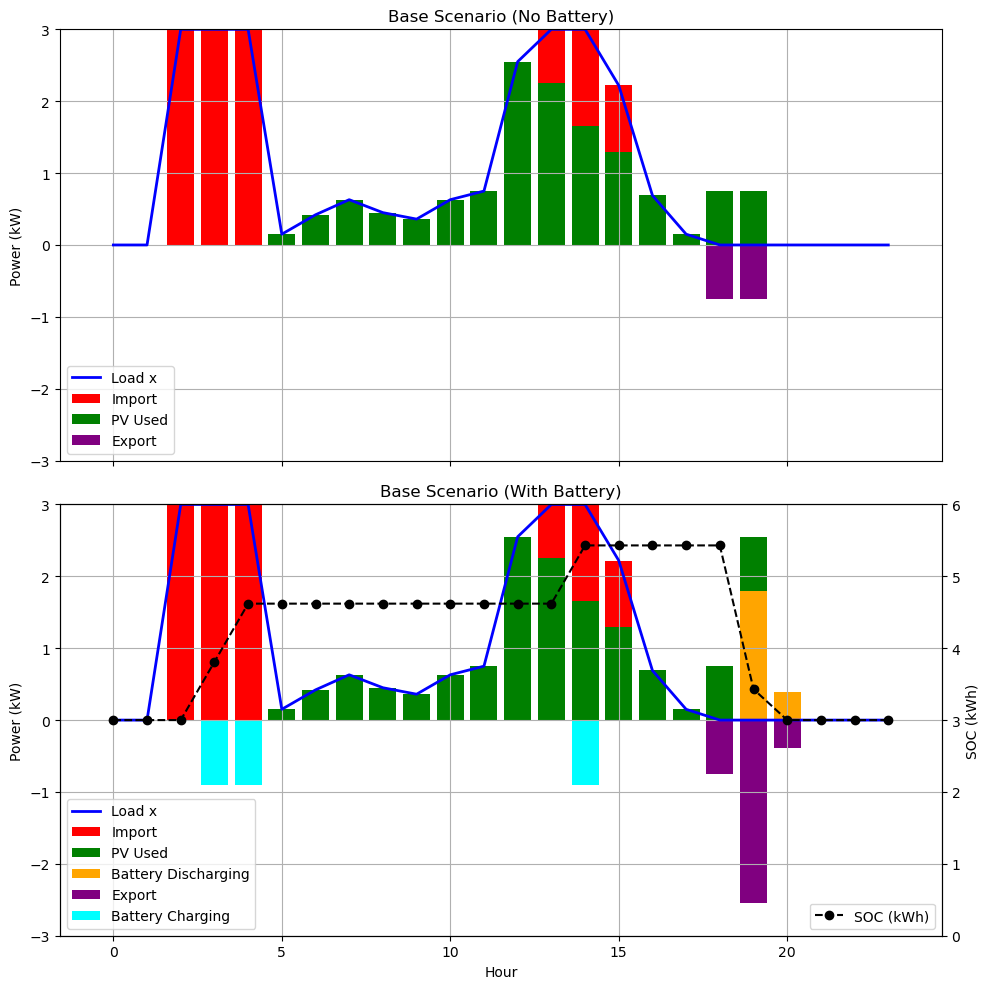

In [ ]:
# ---------- Cost structure simulations with battery storage ----------

E_min = 24.0  # kWh daily minimum energy consumption

# ---------- Define scenarios ----------
scenarios = {
    "Base": {"import_tariff": 0.50, "export_tariff": 0.40},
    "High tariff": {"import_tariff": 1.00, "export_tariff": 0.80},
    "No export tariff": {"import_tariff": 0.50, "export_tariff": 0.00},
    "Zero tariffs": {"import_tariff": 0.00, "export_tariff": 0.00},
}

# ---------- Function to run optimization for each scenario ----------
def run_battery_scenario(import_tariff_value, export_tariff_value):
    m = gp.Model("battery_daily_min")
    m.setParam('OutputFlag', 0)

    # Variables
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")

    p_ch = m.addVars(T, lb=0.0, ub=P_ch_max, name="p_ch")
    p_dis = m.addVars(T, lb=0.0, ub=P_dis_max, name="p_dis")
    SOC = m.addVars(T, lb=0.0, ub=C, name="SOC")

    # Constraints
    pv_cap_constr = {}
    balance_constr = {}
    load_cap_constr = {}
    for t in T:
        pv_cap_constr[t] = m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")
        balance_constr[t] = m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")
        load_cap_constr[t] = m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

    # SoC dynamics
    soc_constr = {}
    soc_constr[0] = m.addConstr(SOC[0] == SOC0 + eta_ch * p_ch[0] - (1.0 / eta_dis) * p_dis[0], name="soc_0")
    for t in T[1:]:
        soc_constr[t] = m.addConstr(SOC[t] == SOC[t-1] + eta_ch * p_ch[t] - (1.0 / eta_dis) * p_dis[t], name=f"soc_{t}")
    terminal_soc_constr = m.addConstr(SOC[T[-1]] >= SOC_final_required, name="terminal_soc")

    # Daily minimum energy
    daily_min_constr = m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min")

    # Objective
    obj = gp.quicksum(
        (prices[t] + import_tariff_value) * I[t] - (prices[t] - export_tariff_value) * E[t]
        for t in T
    )
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()

    # Collect duals (shadow prices)
    duals = {
        "pv_cap": [pv_cap_constr[t].Pi for t in T],
        "balance": [balance_constr[t].Pi for t in T],
        "load_cap": [load_cap_constr[t].Pi for t in T],
        "soc": [soc_constr[t].Pi for t in T],
        "terminal_soc": terminal_soc_constr.Pi,
        "daily_min": daily_min_constr.Pi
    }

    # Return results
    return {
        "import_tariff": import_tariff_value,
        "export_tariff": export_tariff_value,
        "objective": m.ObjVal,
        "total_load": sum(x[t].X for t in T),
        "total_import": sum(I[t].X for t in T),
        "total_export": sum(E[t].X for t in T),
        "total_pv_used": sum(u[t].X for t in T),
        "total_battery_ch": sum(p_ch[t].X for t in T),
        "total_battery_dis": sum(p_dis[t].X for t in T),
        "shadow_price_daily_min": daily_min_constr.Pi,
        "duals": duals,  # ← all constraint duals
        "x": [x[t].X for t in T],
        "I": [I[t].X for t in T],
        "E": [E[t].X for t in T],
        "u": [u[t].X for t in T],
        "p_ch": [p_ch[t].X for t in T],
        "p_dis": [p_dis[t].X for t in T],
        "SOC": [SOC[t].X for t in T],
    }


# ---------- Function to run optimization for each scenario WITHOUT battery ----------
def run_no_battery_scenario(import_tariff_value, export_tariff_value):
    m = gp.Model("no_battery_daily_min")
    m.setParam('OutputFlag', 0)

    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")

    pv_cap_constr = {}
    balance_constr = {}
    load_cap_constr = {}
    for t in T:
        pv_cap_constr[t] = m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")
        balance_constr[t] = m.addConstr(I[t] - E[t] + u[t] == x[t], name=f"balance_{t}")
        load_cap_constr[t] = m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

    daily_min_constr = m.addConstr(gp.quicksum(x[t] for t in T) >= E_min, name="daily_min")

    obj = gp.quicksum(
        (prices[t] + import_tariff_value) * I[t] - (prices[t] - export_tariff_value) * E[t]
        for t in T
    )
    m.setObjective(obj, GRB.MINIMIZE)
    m.optimize()

    duals = {
        "pv_cap": [pv_cap_constr[t].Pi for t in T],
        "balance": [balance_constr[t].Pi for t in T],
        "load_cap": [load_cap_constr[t].Pi for t in T],
        "daily_min": daily_min_constr.Pi
    }

    return {
        "import_tariff": import_tariff_value,
        "export_tariff": export_tariff_value,
        "objective": m.ObjVal,
        "total_load": sum(x[t].X for t in T),
        "total_import": sum(I[t].X for t in T),
        "total_export": sum(E[t].X for t in T),
        "total_pv_used": sum(u[t].X for t in T),
        "shadow_price_daily_min": daily_min_constr.Pi,
        "duals": duals,  # ← all constraint duals
        "x": [x[t].X for t in T],
        "I": [I[t].X for t in T],
        "E": [E[t].X for t in T],
        "u": [u[t].X for t in T],
        "Scenario": None
    }


# ---------- Run all scenarios WITHOUT battery ----------
results_no_battery = []
for name, sc in scenarios.items():
    res = run_no_battery_scenario(sc["import_tariff"], sc["export_tariff"])
    res["Scenario"] = name
    results_no_battery.append(res)

# ---------- Summary for no battery ----------
df_no_batt = pd.DataFrame(results_no_battery)
print("\n=== Scenario Summary (No Battery) ===")
print(df_no_batt[[
    "Scenario", "import_tariff", "export_tariff", "objective",
    "total_load", "total_pv_used", "total_import", "total_export",
    "shadow_price_daily_min"
]].to_string(index=False))

# ---------- Run all scenarios with battery ----------
results = []
for name, sc in scenarios.items():
    res = run_battery_scenario(sc["import_tariff"], sc["export_tariff"])
    res["Scenario"] = name
    results.append(res)

# ---------- Summary with battery ----------
df = pd.DataFrame(results)
print("\n=== Scenario Summary ===")
print(df[[
    "Scenario", "import_tariff", "export_tariff", "objective",
    "total_load", "total_pv_used", "total_import", "total_export",
    "total_battery_ch", "total_battery_dis", "shadow_price_daily_min"
]].to_string(index=False))

"""
# plot the daily schedule for each scenario WITHOUT battery
fig, axs = plt.subplots(len(scenarios), 1, figsize=(10, 5 * len(scenarios)), sharex=True, sharey=True)
for i, (name, sc) in enumerate(scenarios.items()):
    scenario = next(res for res in results_no_battery if res['Scenario'] == name)
    x_sol = np.array(scenario['x'])
    I_sol = np.array(scenario['I'])
    E_sol = np.array(scenario['E'])
    u_sol = np.array(scenario['u'])
    width = 0.8
    axs[i].bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol)
    axs[i].bar(T, u_sol, width=width, label="PV Used", color='green')
    axs[i].bar(T, -E_sol, width=width, label="Export", color='purple')
    axs[i].plot(T, x_sol, label="Load x", color='blue', linewidth=2)
    axs[i].set_title(f"{name} Scenario (No Battery)")
    axs[i].set_ylabel("Power (kW)")
    axs[i].grid()
    axs[i].set_ylim(-3, 3)
    if i == 0:
        axs[i].legend(loc='upper right')
axs[-1].set_xlabel("Hour")
plt.tight_layout()
plt.show()

# plot the daily schedule for each scenario WITH battery
fig, axs = plt.subplots(len(scenarios), 1, figsize=(10, 6 * len(scenarios)), sharex=True, sharey=True)
for i, (name, sc) in enumerate(scenarios.items()):
    scenario = next(res for res in results if res['Scenario'] == name)
    x_sol = np.array(scenario['x'])
    I_sol = np.array(scenario['I'])
    E_sol = np.array(scenario['E'])
    u_sol = np.array(scenario['u'])
    p_ch_sol = np.array(scenario['p_ch'])
    p_dis_sol = np.array(scenario['p_dis'])
    SOC_sol = np.array(scenario['SOC'])

    width = 0.8
    axs[i].bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol + p_dis_sol)
    axs[i].bar(T, u_sol, width=width, label="PV Used", color='green', bottom=p_dis_sol)
    axs[i].bar(T, p_dis_sol, width=width, label="Battery Discharging", color='orange')
    axs[i].bar(T, -E_sol, width=width, label="Export", color='purple')
    axs[i].bar(T, -p_ch_sol, width=width, label="Battery Charging", color='cyan', bottom=-E_sol)
    axs[i].plot(T, x_sol, label="Load x", color='blue', linewidth=2)
    axs[i].set_title(f"{name} Scenario (With Battery)")
    axs[i].set_ylabel("Power (kW)")
    axs[i].grid()
    axs[i].set_ylim(-3, 3)
    if i == 0:
        axs[i].legend(loc='lower left')

    # Secondary axis for SOC, aligned so SOC=3 is at Power=0
    ax2 = axs[i].twinx()
    soc_offset = 3.0  # SOC=3 aligns with Power=0
    power_ylim = axs[i].get_ylim()
    soc_ylim = (soc_offset + power_ylim[0], soc_offset + power_ylim[1])
    ax2.set_ylim(soc_ylim)
    ax2.plot(T, SOC_sol, label="SOC (kWh)", color='black', linestyle='--', marker='o')
    ax2.set_ylabel("SOC (kWh)")
    if i == 0:
        ax2.legend(loc='upper left')
axs[-1].set_xlabel("Hour")
plt.tight_layout()
plt.show()
"""



# plot only the base scenario with and without battery for comparison
base_no_batt = next(res for res in results_no_battery if res['Scenario'] == "Base")
base_batt = next(res for res in results if res['Scenario'] == "Base")
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)
# No battery
x_sol = np.array(base_no_batt['x'])
I_sol = np.array(base_no_batt['I'])
E_sol = np.array(base_no_batt['E'])
u_sol = np.array(base_no_batt['u'])
width = 0.8
axs[0].bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol)
axs[0].bar(T, u_sol, width=width, label="PV Used", color='green')
axs[0].bar(T, -E_sol, width=width, label="Export", color='purple')
axs[0].plot(T, x_sol, label="Load x", color='blue', linewidth=2)
axs[0].set_title("Base Scenario (No Battery)")
axs[0].set_ylabel("Power (kW)")
axs[0].grid()
axs[0].set_ylim(-3, 3)
axs[0].legend(loc='lower left')
# With battery
x_sol = np.array(base_batt['x'])
I_sol = np.array(base_batt['I'])
E_sol = np.array(base_batt['E'])
u_sol = np.array(base_batt['u'])    
p_ch_sol = np.array(base_batt['p_ch'])
p_dis_sol = np.array(base_batt['p_dis'])
SOC_sol = np.array(base_batt['SOC'])
width = 0.8
axs[1].bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol + p_dis_sol)
axs[1].bar(T, u_sol, width=width, label="PV Used", color='green', bottom=p_dis_sol)
axs[1].bar(T, p_dis_sol, width=width, label="Battery Discharging", color='orange')
axs[1].bar(T, -E_sol, width=width, label="Export", color='purple')
axs[1].bar(T, -p_ch_sol, width=width, label="Battery Charging", color='cyan', bottom=-E_sol)
axs[1].plot(T, x_sol, label="Load x", color='blue', linewidth=2)
axs[1].set_title("Base Scenario (With Battery)")
axs[1].set_ylabel("Power (kW)")
axs[1].grid()
axs[1].set_ylim(-3, 3)
axs[1].legend(loc='lower left')
# Secondary axis for SOC, aligned so SOC=3 is at Power=0
ax2 = axs[1].twinx()
soc_offset = 3.0  # SOC=3 aligns with Power=0
power_ylim = axs[1].get_ylim()
soc_ylim = (soc_offset + power_ylim[0], soc_offset + power_ylim[1])
ax2.set_ylim(soc_ylim)
ax2.plot(T, SOC_sol, label="SOC (kWh)", color='black', linestyle='--', marker='o')
ax2.set_ylabel("SOC (kWh)")
ax2.legend(loc='lower right')
axs[-1].set_xlabel("Hour")
plt.tight_layout()
plt.show()




Gamma sweep comparison (with vs without battery):
 gamma  objective_no_batt  objective_with_batt  difference  percent_diff
   0.0          -11.22450           -15.288840    4.064340    -36.209542
   0.5            2.74800            -1.316340    4.064340    147.901747
   1.0           14.25150            11.374833    2.876667     20.185010
   1.5           24.02325            21.594917    2.428333     10.108263
   2.0           29.95215            27.125594    2.826556      9.436904
   2.5           32.34465            27.964483    4.380167     13.542167
   3.0           33.55365            28.048483    5.505167     16.407058


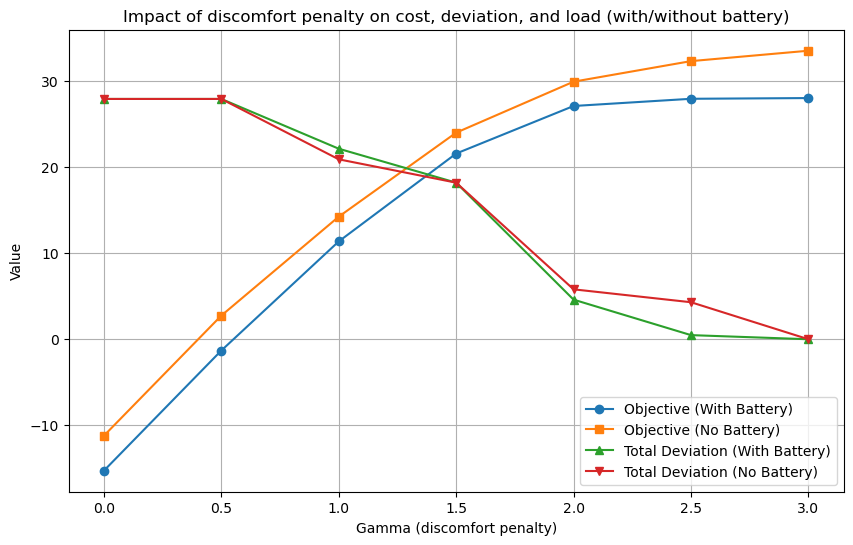

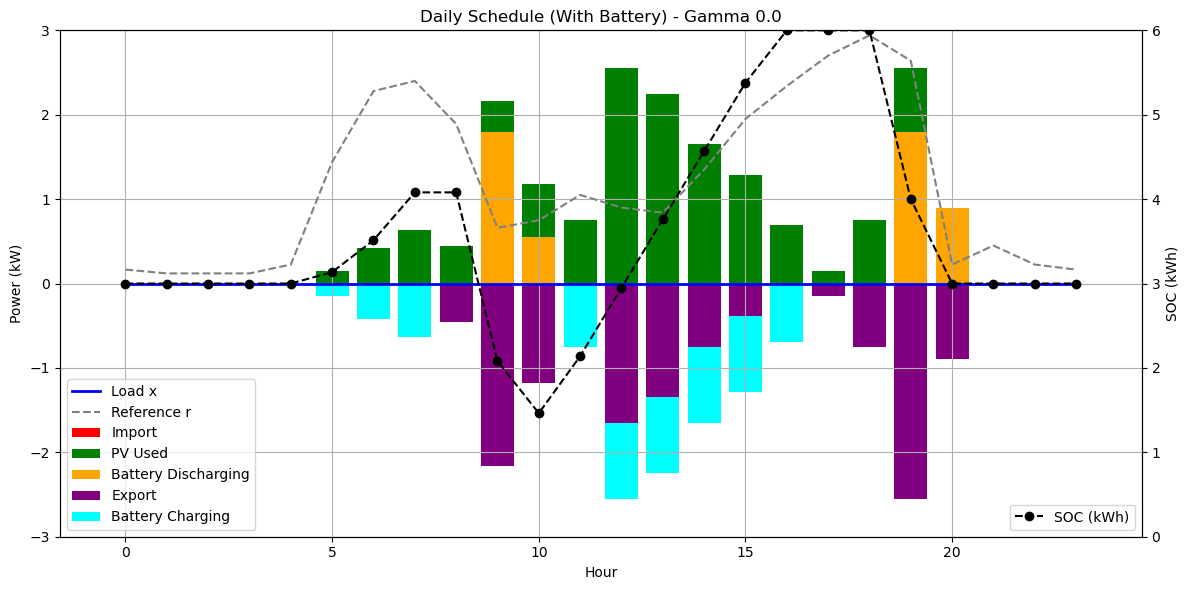

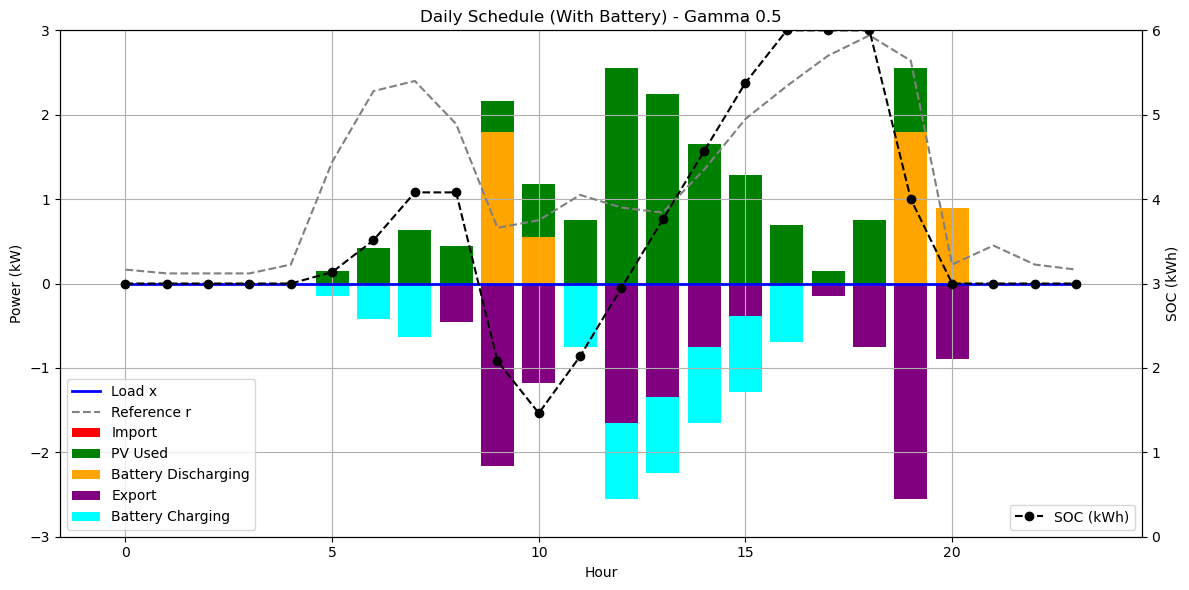

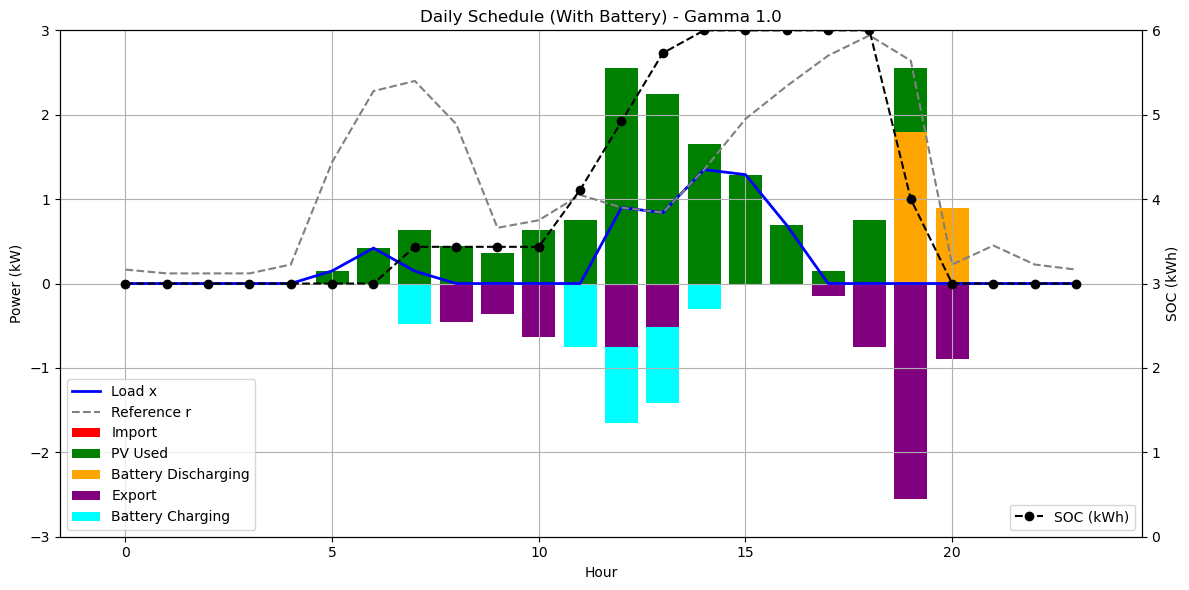

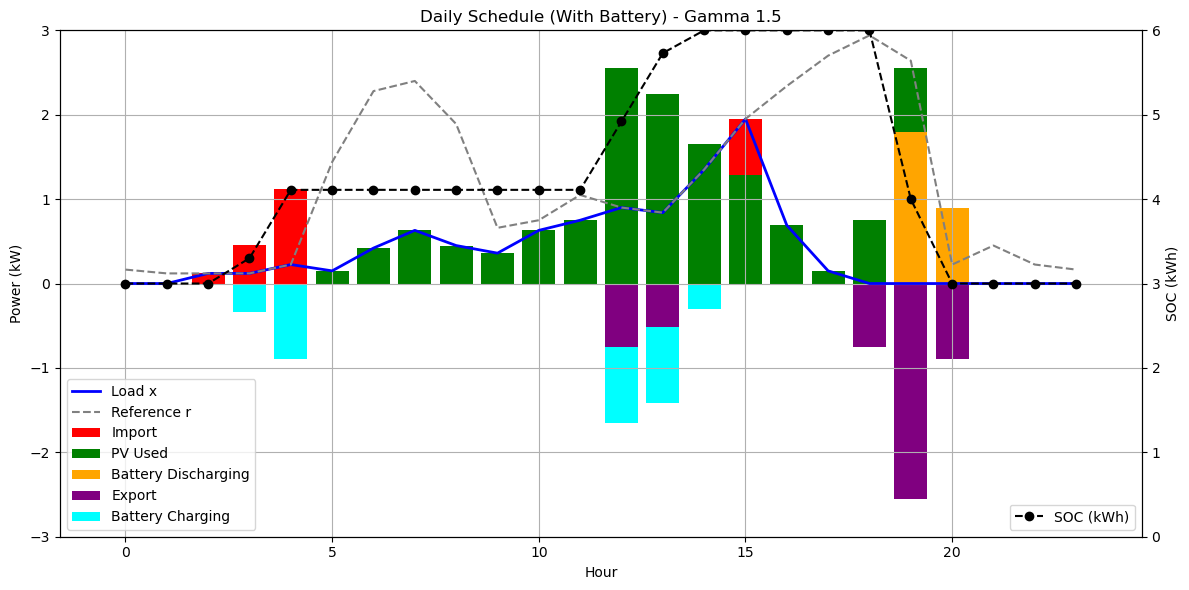

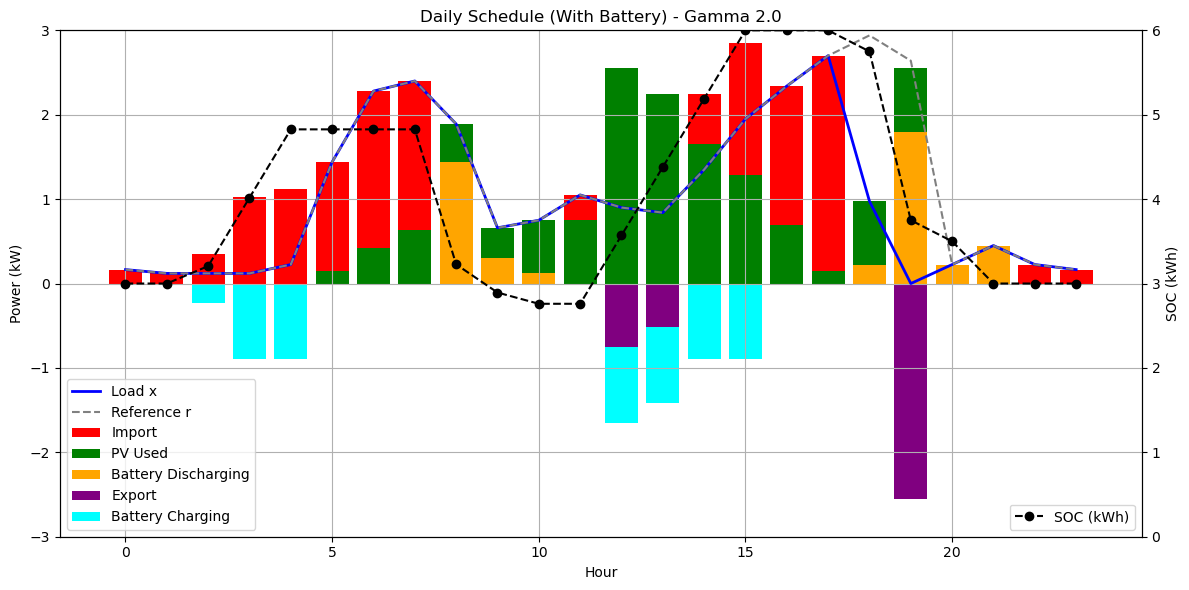

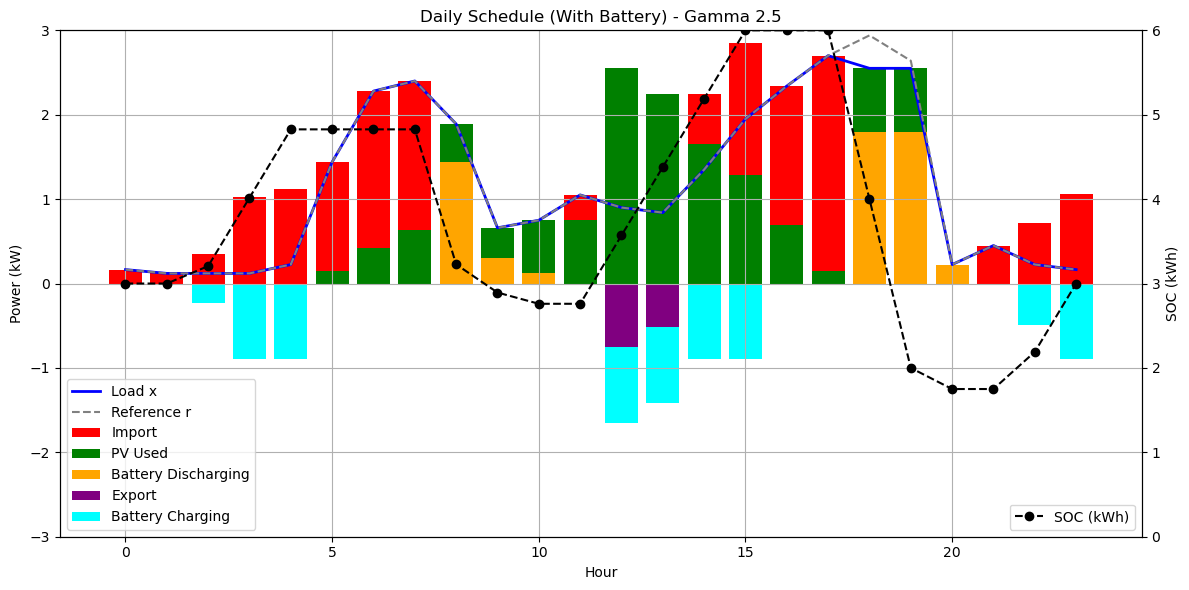

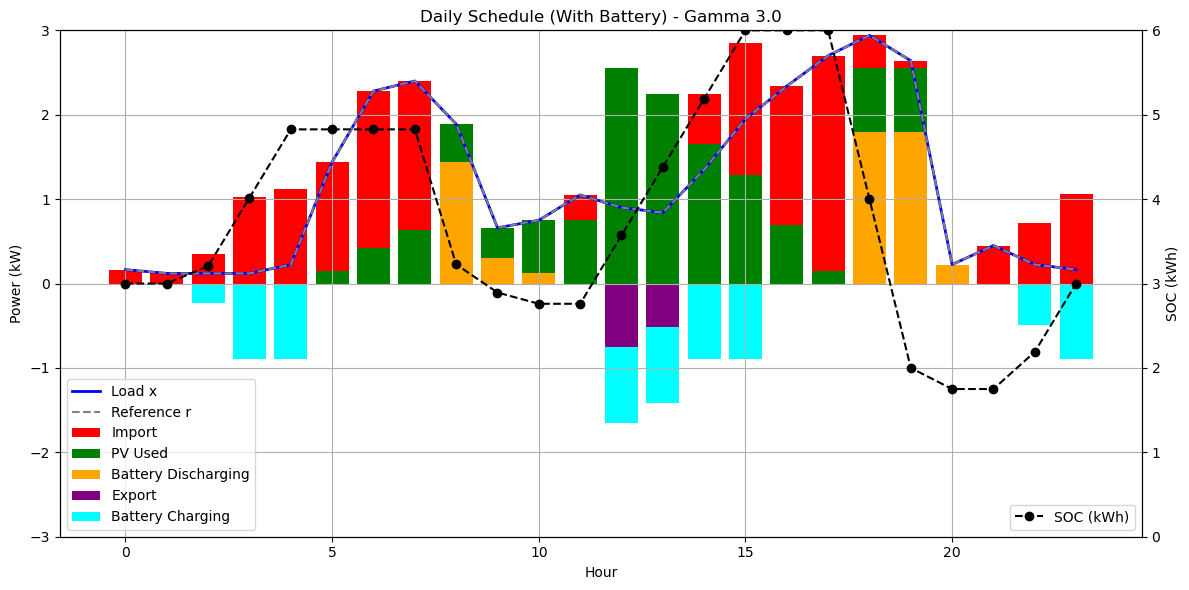

In [ ]:
# ---------- Flexibility preferences simulations with battery storage ----------

# ---------- Functions ----------

def run_with_battery(gamma_value):
    m = gp.Model(f"gamma_{gamma_value}_with_batt")
    m.setParam('OutputFlag', 0)

    # Variables
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")
    d = m.addVars(T, lb=0.0, name="d")

    p_ch = m.addVars(T, lb=0.0, ub=P_ch_max, name="p_ch")
    p_dis = m.addVars(T, lb=0.0, ub=P_dis_max, name="p_dis")
    SOC = m.addVars(T, lb=0.0, ub=C, name="SOC")

    pv_cap = {}
    balance = {}
    for t in T:
        pv_cap[t] = m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")
        balance[t] = m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")
        m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
        m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")

    # Battery dynamics
    m.addConstr(SOC[0] == SOC0 + eta_ch * p_ch[0] - (1.0 / eta_dis) * p_dis[0], name="soc_0")
    for t in T[1:]:
        m.addConstr(SOC[t] == SOC[t-1] + eta_ch * p_ch[t] - (1.0 / eta_dis) * p_dis[t], name=f"soc_{t}")
    m.addConstr(SOC[T[-1]] >= SOC_final_required, name="terminal_soc")

    # Objective
    energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
    discomfort_cost = gamma_value * gp.quicksum(d[t] for t in T)
    m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

    m.optimize()

    return {
        "gamma": gamma_value,
        "objective": m.ObjVal,
        "total_import": sum(I[t].X for t in T),
        "total_export": sum(E[t].X for t in T),
        "total_load": sum(x[t].X for t in T),
        "total_pv_used": sum(u[t].X for t in T),
        "total_battery_ch": sum(p_ch[t].X for t in T),
        "total_battery_dis": sum(p_dis[t].X for t in T),
        "total_deviation": sum(d[t].X for t in T),
        "lambda": [balance[t].Pi for t in T],
        "mu": [pv_cap[t].Pi for t in T],
        "x": [x[t].X for t in T],
        "u": [u[t].X for t in T],
        "I": [I[t].X for t in T],
        "E": [E[t].X for t in T],
        "p_ch": [p_ch[t].X for t in T],
        "p_dis": [p_dis[t].X for t in T],
        "SOC": [SOC[t].X for t in T],
        "d": [d[t].X for t in T],
    }


def run_without_battery(gamma_value):
    m = gp.Model(f"gamma_{gamma_value}_no_batt")
    m.setParam('OutputFlag', 0)

    # Variables
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")
    d = m.addVars(T, lb=0.0, name="d")

    pv_cap = {}
    balance = {}
    for t in T:
        pv_cap[t] = m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")
        balance[t] = m.addConstr(I[t] - E[t] + u[t] == x[t], name=f"balance_{t}")
        m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
        m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")

    energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
    discomfort_cost = gamma_value * gp.quicksum(d[t] for t in T)
    m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

    m.optimize()

    return {
        "gamma": gamma_value,
        "objective": m.ObjVal,
        "total_import": sum(I[t].X for t in T),
        "total_export": sum(E[t].X for t in T),
        "total_load": sum(x[t].X for t in T),
        "total_pv_used": sum(u[t].X for t in T),
        "total_deviation": sum(d[t].X for t in T),
        "lambda": [balance[t].Pi for t in T],
        "mu": [pv_cap[t].Pi for t in T],
        "x": [x[t].X for t in T],
        "u": [u[t].X for t in T],
        "I": [I[t].X for t in T],
        "E": [E[t].X for t in T],
        "d": [d[t].X for t in T],
    }


# ---------- Run gamma sweeps ----------
gamma_vals = np.arange(0, 3.5, 0.5)
results_with_batt = [run_with_battery(g) for g in gamma_vals]
results_no_batt = [run_without_battery(g) for g in gamma_vals]

# ---------- Comparison DataFrame ----------
df_with = pd.DataFrame(results_with_batt)
df_no = pd.DataFrame(results_no_batt)

df_compare = pd.DataFrame({
    "gamma": gamma_vals,
    "objective_no_batt": df_no["objective"],
    "objective_with_batt": df_with["objective"],
})
df_compare["difference"] = df_compare["objective_no_batt"] - df_compare["objective_with_batt"]
df_compare["percent_diff"] = 100 * df_compare["difference"] / df_compare["objective_no_batt"]

print("\nGamma sweep comparison (with vs without battery):")
print(df_compare.to_string(index=False))

# ---------- Plot: Objective vs Gamma ----------
plt.figure(figsize=(10, 6))
plt.plot(df_compare["gamma"], df_with["objective"], marker="o", label="Objective (With Battery)")
plt.plot(df_compare["gamma"], df_no["objective"], marker="s", label="Objective (No Battery)")
plt.plot(df_compare["gamma"], df_with["total_deviation"], marker="^", label="Total Deviation (With Battery)")
plt.plot(df_compare["gamma"], df_no["total_deviation"], marker="v", label="Total Deviation (No Battery)")
plt.xlabel("Gamma (discomfort penalty)")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.title("Impact of discomfort penalty on cost, deviation, and load (with/without battery)")
plt.show()

# Barplot for each gamma value (with battery only)
for res in results_with_batt:
    x_sol = np.array(res['x'])
    I_sol = np.array(res['I'])
    E_sol = np.array(res['E'])
    u_sol = np.array(res['u'])
    p_ch_sol = np.array(res['p_ch'])
    p_dis_sol = np.array(res['p_dis'])
    SOC_sol = np.array(res['SOC'])
    width = 0.8

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(T, I_sol, width=width, label="Import", color='red', bottom=u_sol + p_dis_sol)
    ax1.bar(T, u_sol, width=width, label="PV Used", color='green', bottom=p_dis_sol)
    ax1.bar(T, p_dis_sol, width=width, label="Battery Discharging", color='orange')
    ax1.bar(T, -E_sol, width=width, label="Export", color='purple')
    ax1.bar(T, -p_ch_sol, width=width, label="Battery Charging", color='cyan', bottom=-E_sol)
    ax1.plot(T, x_sol, label="Load x", color='blue', linewidth=2)
    ax1.plot(T, r, label="Reference r", color='grey', linestyle='--')
    ax1.set_title(f"Daily Schedule (With Battery) - Gamma {res['gamma']}")
    ax1.set_ylabel("Power (kW)")
    ax1.set_ylim(-3, 3)
    ax1.grid()
    ax1.legend(loc='lower left')

    # Secondary axis for SOC, aligned so SOC=3 is at Power=0
    ax2 = ax1.twinx()
    soc_offset = 3.0
    power_ylim = ax1.get_ylim()
    soc_ylim = (soc_offset + power_ylim[0], soc_offset + power_ylim[1])
    ax2.set_ylim(soc_ylim)
    ax2.plot(T, SOC_sol, label="SOC (kWh)", color='black', linestyle='--', marker='o')
    ax2.set_ylabel("SOC (kWh)")
    ax2.legend(loc='lower right')
    ax1.set_xlabel("Hour")
    plt.tight_layout()
    plt.show()


